In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

In [2]:
#creating the dataloaders

In [3]:
# Mean and std dev of the grayscale channel in the MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3081

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray,),(stddev_gray,))])
mnist_train = datasets.MNIST('./data', train = True, download = True, transform = transform)
mnist_valid = datasets.MNIST('./data', train = False, download = True, transform = transform)

In [4]:
# visualize one of the images
mean_gray = 0.1307
stddev_gray = 0.3081
# convert from standardised form to default one to visualise
img = mnist_train[12][0].numpy() * stddev_gray + mean_gray

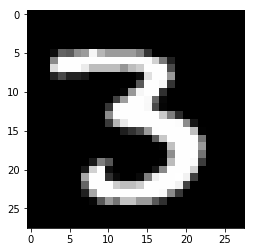

In [5]:
plt.imshow(img.reshape(28,28), cmap='gray')

In [6]:
# Check the lablel
mnist_train[12][1]

3

In [7]:
# Creating the data loaders to feed this into the nwtwork
batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(dataset = mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(dataset = mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

In [8]:
# Create the CNN model
class MNISTNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        # We use default padding of 0 and stride of 1
        
        # Conv layer 1 #28 x 28 x 1
        self.conv1 = nn.Conv2d(1, 20, kernel_size = 5) #24 x 24 x 20
        # non linearity
        self.relu1 = nn.ReLU() # same as above
        
        # Conv layer 2
        self.conv2 = nn.Conv2d(20, 30, kernel_size = 5) # 20 X 20 x 30
        self.conv2_drop = nn.Dropout2d(p=0.5) # same as above
        self.maxpool2 = nn.MaxPool2d(2) # 10 x 10 x 30
        self.relu2 = nn.ReLU() # same as above
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(3000, 500)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        
        # Conv layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        
        # Conv layer 2
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch the view from grid representation to vector representation
        x = x.view(-1, 3000)
        
        # FC Layer 1
        x = self.fc1(x)
        x = F.relu(x) # functional relu
        x = F.dropout(x, training = True) # Because there are a lot of neurons in fc layer
        
        #FC layer 2
        x = self.fc2(x)
        
        return x

In [9]:
# Initialize the model
net = MNISTNet()

if cuda.is_available():
    net = net.cuda()

# Loss Function
criterion = nn.CrossEntropyLoss()

# optimiser
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)

In [10]:
# Training Loop

num_epochs = 100
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    # Put the network in training mode
    net.train()
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        items = Variable(items)
        classes = Variable(classes)
        
        # shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad() # clear off gradients from any past operations
        outputs = net(items)
        loss = criterion(outputs, classes)
        iter_loss += loss.data[0]
        loss.backward()
        optimizer.step()
        
        # Record the correct predictions in training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted==classes.data).sum()
        iterations += 1
        
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(correct/len(mnist_train_loader.dataset))
    
    # Validation Set verification
    loss = 0.0
    correct = 0
    iterations = 0
    
    # In eval mode backprop and dropouts are disabled
    net.eval()
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        items = Variable(items)
        classes = Variable(classes)
        
        # shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)
        loss += criterion(outputs, classes).data[0]
        
        # Record the correct predictions in training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted==classes.data).sum()
        iterations += 1
        
    valid_loss.append(loss/iterations)
    valid_accuracy.append((correct/len(mnist_valid_loader.dataset)*100))
    
    print('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'%(epoch + 1, num_epochs, train_loss[-1], 
                                                                    train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

Epoch 1/100, Tr Loss: 1.1554, Tr Acc: 0.6292, Val Loss: 0.3485, Val Acc: 89.2900
Epoch 2/100, Tr Loss: 0.3428, Tr Acc: 0.8986, Val Loss: 0.2244, Val Acc: 93.2000
Epoch 3/100, Tr Loss: 0.2484, Tr Acc: 0.9266, Val Loss: 0.1661, Val Acc: 95.0800
Epoch 4/100, Tr Loss: 0.1994, Tr Acc: 0.9405, Val Loss: 0.1376, Val Acc: 95.9900
Epoch 5/100, Tr Loss: 0.1697, Tr Acc: 0.9504, Val Loss: 0.1205, Val Acc: 96.2700
Epoch 6/100, Tr Loss: 0.1496, Tr Acc: 0.9550, Val Loss: 0.1035, Val Acc: 96.7100
Epoch 7/100, Tr Loss: 0.1341, Tr Acc: 0.9600, Val Loss: 0.0943, Val Acc: 96.9700
Epoch 8/100, Tr Loss: 0.1220, Tr Acc: 0.9638, Val Loss: 0.0883, Val Acc: 97.2500
Epoch 9/100, Tr Loss: 0.1130, Tr Acc: 0.9661, Val Loss: 0.0796, Val Acc: 97.3800
Epoch 10/100, Tr Loss: 0.1016, Tr Acc: 0.9695, Val Loss: 0.0738, Val Acc: 97.7100
Epoch 11/100, Tr Loss: 0.0962, Tr Acc: 0.9701, Val Loss: 0.0685, Val Acc: 97.8800
Epoch 12/100, Tr Loss: 0.0904, Tr Acc: 0.9731, Val Loss: 0.0675, Val Acc: 97.8400
Epoch 13/100, Tr Loss: 0.

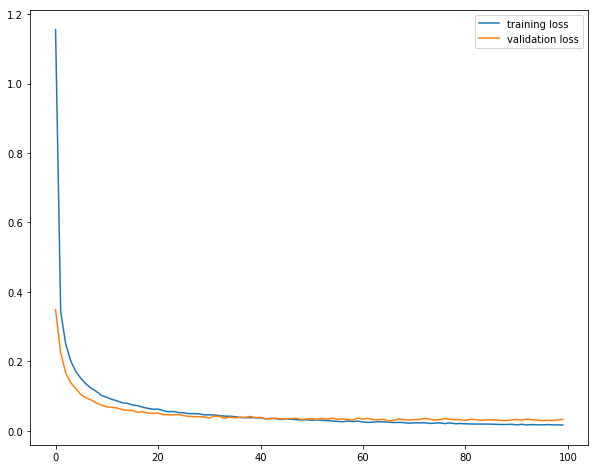

In [11]:
# Visualize the train and validation loss and accuracy
f = plt.figure(figsize=(10,8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

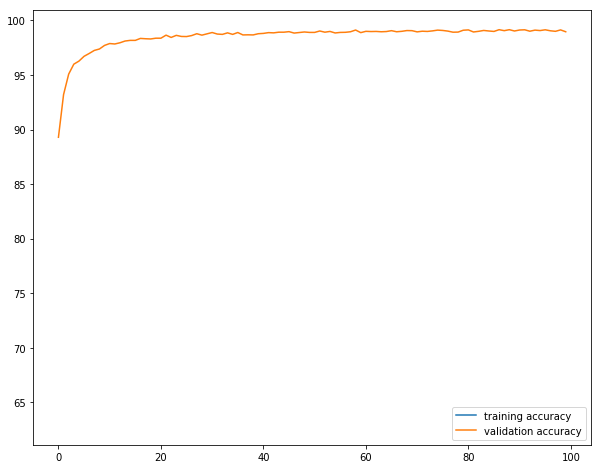

In [22]:
f = plt.figure(figsize=(10,8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

### Inferencing on a single record

In [25]:
image_index = 23
img = mnist_valid[image_index][0].resize_((1,1,28,28))

img = Variable(img)
label = mnist_valid[image_index][1]

net.eval()

if cuda.is_available():
    img = img.cuda()
    net = net.cuda()
else:
    img = img.cpu()
    net = net.cpu()

output = net(img)    

In [26]:
output.data



Columns 0 to 7 
 -9.1178 -19.3321  -6.7768  15.3068  -7.2763  36.6736  -1.2640 -19.2661

Columns 8 to 9 
 -6.9253  15.7650
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

In [27]:
_, predicted = torch.max(output.data, 1)
print('prediction is:', predicted)

prediction is: 
 5
[torch.cuda.LongTensor of size 1 (GPU 0)]



In [28]:
label

5

In [29]:
# Regularization can be applied by using data augmentation and test time augmentation by adding random noise to images

Award winning models

https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html